# Northwind database
##### Jonathan Tyler

Northwind is a company that sells specialty foods. 

I was given a mandate to  "__do something with this database__" as my first project as a new hire. 

I was able to find a entity-relation diagram for the database but not much else. So to break down this task:
1. First I am going to have to explore the database myself to see the basic metrics of the company.
2. Then I will use this basic data to formulate some hypotheses concerning some underlying trends.
3. Finally I will attempt to test out these ideas to prove myself right or wrong.

## EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sqlalchemy
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session, sessionmaker

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import levene, shapiro, mannwhitneyu, kruskal

plt.style.use('ggplot')

Connecting the database enable to start looking at the data. I plan to compare the ERD to the database and get basic metric from the tables.

In [2]:
#engine = create_engine('sqlite:///Northwind_large.sqlite', echo=True)
engine = create_engine('sqlite:///Northwind_small.sqlite', echo=True)
Session = sessionmaker(bind=engine)
session = Session()

inspector = inspect(engine) #checking the ERD against the actual database
inspector.get_table_names()

2020-02-10 11:18:06,302 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-02-10 11:18:06,321 INFO sqlalchemy.engine.base.Engine ()
2020-02-10 11:18:06,329 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-02-10 11:18:06,333 INFO sqlalchemy.engine.base.Engine ()
2020-02-10 11:18:06,372 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-02-10 11:18:06,376 INFO sqlalchemy.engine.base.Engine ()


['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']

  
So a quick check of the different tables align with the ERD. That is good. But I should be checking out the individual tables before calling them nevertheless, it is good pratice.
  
Now lets start checking out a few things:
- How much of what are we selling?
- Who are our main suppliers?
- What does our customer base look like?
- What is the geographical spread of our workforce?

Once we know these things, we will have a broad overview of the business. From there we will investigate any abnormalities or go splunking for underlying trends.
___
---
Now lets make a connection to the engine and make sure it works.

In [3]:
con = engine.connect() #connecting the engine to be able to make queries

In [7]:
q = """
SELECT *
FROM [Order] #simple query get everything from [Order]
""" 
df_order = pd.read_sql_query(q, engine) #puts the information from the query into a dataframe
df_order.head()

2020-02-10 11:24:03,266 INFO sqlalchemy.engine.base.Engine 
SELECT *
FROM [Order]

2020-02-10 11:24:03,270 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


Fantasic, now lets start flushing out answers to those inital questions

## How much of what are we selling?

Lets check the Product table and the Order Detail table

Looks like the table is ERD is wrong again. Some of the tables are incorrectly stated i.e. ProductID is just Id

In [11]:
q='''SELECT p.ProductName, c.CategoryName, SUM(o.Quantity) num_ordered \
FROM Product p \
LEFT JOIN OrderDetail o ON o.ProductId = p.Id \
LEFT JOIN Category c ON c.Id = p.CategoryId \
GROUP BY p.ProductName ORDER BY num_ordered DESC'''
df1 = pd.read_sql_query(q, engine)
df1.head()

2020-02-10 11:29:22,156 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, c.CategoryName, SUM(o.Quantity) num_ordered FROM Product p LEFT JOIN OrderDetail o ON o.ProductId = p.Id LEFT JOIN Category c ON c.Id = p.CategoryId GROUP BY p.ProductName ORDER BY num_ordered DESC
2020-02-10 11:29:22,161 INFO sqlalchemy.engine.base.Engine ()


,ProductName,CategoryName,num_ordered
0,Camembert Pierrot,Dairy Products,1577
1,Raclette Courdavault,Dairy Products,1496
2,Gorgonzola Telino,Dairy Products,1397
3,Gnocchi di nonna Alice,Grains/Cereals,1263
4,Pavlova,Confections,1158


In [14]:
#value_counts of the categories
df1['CategoryName'].value_counts()

Confections       13
Condiments        12
Seafood           12
Beverages         12
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Name: CategoryName, dtype: int64


## Who are our main suppliers?

In [15]:
q = '''SELECT s.CompanyName, s.Region, COUNT(*) num_of_orders FROM [Order] o \
LEFT JOIN OrderDetail od ON o.Id = od.OrderId \
LEFT JOIN Product p ON od.ProductId = p.Id \
LEFT JOIN Supplier s ON p.SupplierId = s.Id \
GROUP BY s.CompanyName \
ORDER BY num_of_orders DESC'''

df2 = pd.read_sql_query(q, engine)
df2.head()

2020-02-10 11:31:24,664 INFO sqlalchemy.engine.base.Engine SELECT s.CompanyName, s.Region, COUNT(*) num_of_orders FROM [Order] o LEFT JOIN OrderDetail od ON o.Id = od.OrderId LEFT JOIN Product p ON od.ProductId = p.Id LEFT JOIN Supplier s ON p.SupplierId = s.Id GROUP BY s.CompanyName ORDER BY num_of_orders DESC
2020-02-10 11:31:24,668 INFO sqlalchemy.engine.base.Engine ()


,CompanyName,Region,num_of_orders
0,Plutzer Lebensmittelgroßmärkte AG,Western Europe,179
1,"Pavlova, Ltd.",Victoria,163
2,"Specialty Biscuits, Ltd.",British Isles,126
3,Gai pâturage,Western Europe,105
4,Norske Meierier,Scandinavia,105


In [18]:
#value_counts to see what region
#average number of orders
display(df2['Region'].value_counts())
print('mean', df2['num_of_orders'].mean())

Western Europe     6
North America      6
Northern Europe    4
Southern Europe    3
British Isles      2
Eastern Asia       2
Scandinavia        2
NSW                1
South-East Asia    1
South America      1
Victoria           1
Name: Region, dtype: int64

mean 74.3103448275862


In [21]:
q = """
SELECT LastName, Title, Region 
FROM Employee
"""
#query of where our employees are using the Employee table
df2 = pd.read_sql_query(q, engine)
df2.head()

2020-02-10 11:38:56,237 INFO sqlalchemy.engine.base.Engine 
SELECT LastName, Title, Region
FROM Employee

2020-02-10 11:38:56,242 INFO sqlalchemy.engine.base.Engine ()


,LastName,Title,Region
0,Davolio,Sales Representative,North America
1,Fuller,"Vice President, Sales",North America
2,Leverling,Sales Representative,North America
3,Peacock,Sales Representative,North America
4,Buchanan,Sales Manager,British Isles


In [27]:
#now check out where all the regions these people are from
df2.Region.value_counts()

North America    5
British Isles    4
Name: Region, dtype: int64

# 2) Is there a difference in the money generated from sales between the North America office and the British Island office?

The employees of this company are based in two central locations. I want to know if one office is better at business than the other. The metric will be money generated (products ordered * price) with the differential based on one office or another.

$H_{o} =$ The employees based out of the British Island office generates the same amount revenue, per order, than the North American office.  
$H_{a} =$ The employees based out of the British Island office generates less revenue, per order, than the North American office.  
$\alpha = 0.05$

### 2-1 Inital Analysis


In [48]:
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS generated, e.Region AS employ_from \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Employee e ON o.EmployeeId = e.Id
GROUP BY od.OrderId'''

df = pd.read_sql_query(q, engine)
df.head(10)

2020-02-10 11:59:32,302 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS generated, e.Region AS employ_from FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN Employee e ON o.EmployeeId = e.Id
GROUP BY od.OrderId
2020-02-10 11:59:32,306 INFO sqlalchemy.engine.base.Engine ()


,OrderId,generated,employ_from
0,10248,440.0,British Isles
1,10249,1863.4,British Isles
2,10250,1813.0,North America
3,10251,670.8,North America
4,10252,3730.0,North America
5,10253,1444.8,North America
6,10254,625.2,British Isles
7,10255,2490.5,British Isles
8,10256,517.8,North America
9,10257,1119.9,North America


In [31]:
print(df.shape)
display(df.describe())
display(df.head())

(830, 3)


,OrderId,generated
count,830.000000,830.000000
mean,10662.500000,1631.877819
std,239.744656,1990.613963
min,10248.000000,12.500000
25%,10455.250000,480.000000
50%,10662.500000,1015.900000
75%,10869.750000,2028.650000
max,11077.000000,17250.000000


,OrderId,generated,employ_from
0,10248,440.0,British Isles
1,10249,1863.4,British Isles
2,10250,1813.0,North America
3,10251,670.8,North America
4,10252,3730.0,North America


Looks like we have all 830 orders. Great.

In [36]:
#Find group by the employ_from and then describe the generated amount
df.groupby('employ_from')['generated'].describe().T

employ_from,British Isles,North America
count,224.000000,606.000000
mean,1687.615357,1611.275165
std,2203.222396,1907.580217
min,12.500000,18.400000
25%,480.000000,481.100000
50%,930.125000,1070.500000
75%,2023.650000,2028.650000
max,16321.900000,17250.000000


The average made by both offices are close to each other but there is far fewer sales made by the British office. Lets take a quick look at the distribution for both, but look at the above data there is likely to be outliers.

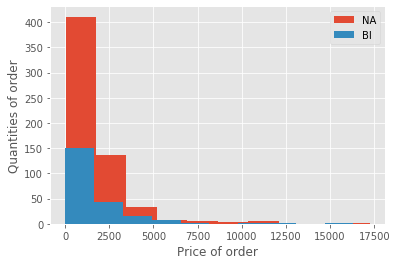

In [37]:
plt.hist('generated', data=df[df.employ_from == 'North America'], label= 'NA')
plt.hist('generated', data=df[df.employ_from == 'British Isles'], label= 'BI')
plt.legend()
plt.ylabel('Quantities of order')
plt.xlabel('Price of order')
#plt.savefig('hist money')

There seems to be a few outliers. Lets take care of the egregious ones i.e. anything above 11K

In [46]:
df.generated.sort_values(ascending=False).head(10)

649    10835.24
105    10741.60
267    10588.50
231    10495.60
292    10191.70
443    10164.80
784     8902.50
568     8891.00
266     8623.45
664     8267.40
Name: generated, dtype: float64

In [49]:
to_drop = [617,782,733,124,176,569,641,169]
df.drop(index=to_drop,inplace=True)

In [53]:
#make two new dfs. One that contains all the employees that are employed out of British Isles and a group from North America
#Then describe them both

brit = df[df['employ_from'] == 'British Isles']
merica = df[df['employ_from'] == 'North America']

display(merica.describe())
display(brit.describe())

,OrderId,generated
count,602.000000,602.000000
mean,10660.827243,1529.233970
std,241.085475,1611.180311
min,10250.000000,18.400000
25%,10449.250000,479.762500
50%,10659.000000,1061.200000
75%,10870.750000,1972.202500
max,11077.000000,10835.240000


,OrderId,generated
count,220.000000,220.000000
mean,10664.827273,1484.316091
std,235.640635,1594.673307
min,10248.000000,12.500000
25%,10487.500000,479.850000
50%,10666.500000,920.300000
75%,10868.250000,1943.500000
max,11074.000000,10741.600000


## 2-2 Testing

### Mann–Whitney U test

Mann–Whitney U test is a nonparametric test of the null hypothesis that it is equally likely that a randomly selected value from one sample will be less than or greater than a randomly selected value from a second sample.

Unlike the t-test it does not require the assumption of normal distributions. It is nearly as efficient as the t-test on normal distributions.

Mann-Whitney assumptions:  
1) The dependent variable should be measured on an ordinal scale or a continuous scale.  
2) The independent variable should be two independent, categorical groups.  
3) Observations should be independent. In other words, there should be no relationship between the two groups or within each group.  
4) Observations are not normally distributed. However, they should follow the same shape (i.e. both are bell-shaped and skewed left).  


All assumptions are met within our data. So finally, refining our hypothesis: 

$H_{o} =$ There is no statistical difference between the meadian revenues generated by the North American office and the British Island office.  
$H_{a} =$ There is a statistical difference between the meadian revenues generated by the North American office and the British Island office.  
$\alpha = 0.05$

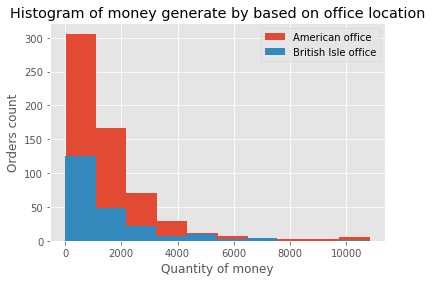

In [54]:
merica['generated'].hist(label='American office')
brit['generated'].hist(label='British Isle office')
plt.title('Histogram of money generate by based on office location')
plt.xlabel('Quantity of money')
plt.ylabel('Orders count')
plt.legend()
plt.show()
#plt.savefig('hist of money gen')

In [55]:
mannwhitneyu(brit.generated, merica.generated, alternative='two-sided')

MannwhitneyuResult(statistic=63545.5, pvalue=0.3749479529063807)

#### Independent T-test

Like every test, this inferential statistic test has assumptions. The assumptions that the data must meet in order for the test results to be valid are:  

Independent T-test Assumptions
- The samples are independently and randomly drawn
- The distribution of the residuals between the two groups should follow the normal distribution
- The variances between the two groups are equal

The first assumption is met. The second assumption can be suspended given a large enough sample size, therefore independent t-test remains quite robust for violations of normality. [More information](http://thestatsgeek.com/2013/09/28/the-t-test-and-robustness-to-non-normality/) on this topic has been provided.

Keep in mind that as a parametric test, the independent t-test delivers best and most reliable results if both groups are normally distributed. Reliability decreases for skewed distributions.

In [56]:
ttest_ind(brit.generated, merica.generated)

Ttest_indResult(statistic=-0.35484137300003266, pvalue=0.722799672488631)

### 2-3 Results

- Failed to reject the null hypothesis. There is no statistical difference between the median revenues generated by the North American office and the British Island office 
- (p-value > $\alpha$ :: 0.3749 > 0.05)  
- Further testing: choosing a different metric and test out hypothesis again.
___
___

# 3) Does having 'manager' in your title effect the amount a customer orders?


### 3-1 Inital Analysis
The customers that we do business with, there are different tiers of titles that they use. I want to know if a manager typically orders more than other customers.

$H_{o} =$ Having manager in your title, the amount a customer orders doesn't change  
$H_{a} =$ Having manager in your title, the amount a customer orders changes  
$\alpha = 0.05$

In [ ]:
get_column_info('Customer')

In [ ]:
q = '''SELECT c.CompanyName, c.ContactTitle, COUNT(*) AS orders_placed \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Customer c ON c.Id = o.CustomerId \
GROUP BY c.CompanyName'''

df = pd.read_sql_query(q, engine)
df.head(10)

In [ ]:
df.orders_placed.sum()

Good, we have all of the orders placed. There seems be a few ghost orders, someone placing some personal orders, or some testing data. Nevertheless, I will need to remove them.

In [ ]:
df.drop(index=0, inplace=True)
df.describe()

Now encoding manager title vs no mananger title.

In [ ]:
df['is_mgmt'] = np.where(df.ContactTitle.str.contains('anager'),1,0) #also could have used .lower() to include the full word

In [ ]:
df.head(10)

In [ ]:
plt.figure(figsize=(12,12))
sns.violinplot(y='orders_placed',x='is_mgmt', data=df)
plt.title('Violin plots: comparing the distribution of management vs non-management')
plt.xlabel('Is management')
plt.ylabel('Number of items in order');

In [ ]:
df.groupby('is_mgmt').orders_placed.idxmax(),df.groupby('is_mgmt').orders_placed.max()

In [ ]:
df.drop(index=[66,19], inplace=True)
#df.drop(index=[57], inplace=True)

In [ ]:
plt.figure(figsize=(12,12))
sns.violinplot(y='orders_placed',x='is_mgmt', data=df)
plt.title('Violin plots: comparing the distribution of management vs non-management')
plt.xlabel('Is management')
plt.ylabel('Number of items in order');

## 3-2 Testing

I will perform both the independent T-test as well as Mann-Whitney U test.  

See section 2-2 for supporting documentation

In [ ]:
mgmt_yes = df.orders_placed[df.is_mgmt == 1]
mgmt_no = df.orders_placed[df.is_mgmt == 0]
ttest_ind(mgmt_yes, mgmt_no)

In [ ]:
mannwhitneyu(mgmt_no, mgmt_yes)

## 3-3 Results

- Failed to reject the null hypothesis. As a customer having manager in your title, the quantity ordered _doesn't signifgantly change_ compared to customers without that title  
- p-value > $\alpha$ :: 0.2241 > 0.05
- Further testing: change the criteria in which the customers are grouped. Include 'owner' title with the 'manager' title and compare results.
___
___

RESOUCES:

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3116565/

https://pythonfordatascience.org/